In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
from os.path import join
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

from keras import models, regularizers, layers, optimizers, losses, metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils, to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications import ResNet50

In [3]:
import tensorflow as tf 
import numpy as np
import os
import matplotlib.pyplot as plt 
def listdir_nohidden(path):
    for f in os.listdir(path):
        if not f.startswith('.'):
            yield f

rawdir = listdir_nohidden('/content/drive/MyDrive/301data/mangaFacialExpression')
Name = sorted(rawdir)
n = len(Name)
N = list(range(n))
string_to_num_mapping = dict(zip(Name,N)) 
num_to_string_mapping = dict(zip(N,Name)) 

In [4]:
img_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    brightness_range=(0.5,1),
    channel_shift_range=0.2,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=1./255,
    validation_split=0.3
)
root_dir = '/content/drive/MyDrive/301data/mangaFacialExpression'

img_generator_flow_train = img_generator.flow_from_directory(
    directory=root_dir,
    target_size=(224, 224),
    batch_size=32,
    shuffle=True,
    class_mode='categorical',
    subset="training")

img_generator_flow_valid = img_generator.flow_from_directory(
    directory=root_dir,
    target_size=(224, 224),
    batch_size=32,
    shuffle=True,
    class_mode='categorical',
    subset="validation")



Found 264 images belonging to 7 classes.
Found 108 images belonging to 7 classes.


In [5]:
imgs, labels = next(iter(img_generator_flow_train))
for img, label in zip(imgs, labels):
    value=np.argmax(label)
    plt.imshow(img)
    plt.title(num_to_string_mapping[value])
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Base ResNet, pretrained using ImageNet

In [6]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

base_model_resnset = ResNet50(weights='imagenet',
include_top=False,
input_shape=(224, 224, 3))

print(base_model_resnset.summary())
model = models.Sequential()
model.add(base_model_resnset)
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dense(7, activation='sigmoid'))

print(model.summary())

94765736/94765736 [==============================] - 2s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

In [7]:
# Base layer should not be trainable
for layer in base_model_resnset.layers[:]:
   layer.trainable = False


In [8]:
model.compile(optimizer=optimizers.Adam(learning_rate = 0.0001),
              loss= tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Accuracy()])

In [9]:
history = model.fit(img_generator_flow_train, 
          validation_data=img_generator_flow_valid, epochs=100) 

Epoch 1/100
9/9 [==============================] - 53s 5s/step - loss: 2.2824 - categorical_accuracy: 0.2159 - accuracy: 0.0000e+00 - val_loss: 1.8889 - val_categorical_accuracy: 0.2593 - val_accuracy: 0.0000e+00
Epoch 2/100
9/9 [==============================] - 2s 257ms/step - loss: 1.8546 - categorical_accuracy: 0.2386 - accuracy: 0.0000e+00 - val_loss: 1.7621 - val_categorical_accuracy: 0.2685 - val_accuracy: 0.0000e+00
Epoch 3/100
9/9 [==============================] - 2s 240ms/step - loss: 1.7047 - categorical_accuracy: 0.3220 - accuracy: 0.0000e+00 - val_loss: 1.6956 - val_categorical_accuracy: 0.3148 - val_accuracy: 0.0000e+00
Epoch 4/100
9/9 [==============================] - 2s 244ms/step - loss: 1.6592 - categorical_accuracy: 0.3485 - accuracy: 0.0000e+00 - val_loss: 1.6923 - val_categorical_accuracy: 0.3519 - val_accuracy: 0.0000e+00
Epoch 5/100
9/9 [==============================] - 2s 243ms/step - loss: 1.5728 - categorical_accuracy: 0.4432 - accuracy: 0.0000e+00 - val_lo

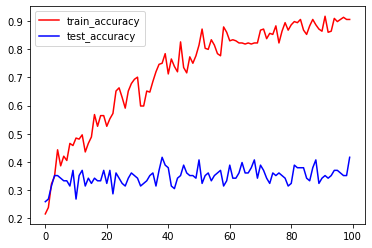

In [10]:
plt.plot(history.history["categorical_accuracy"], c="r", label="train_accuracy")
plt.plot(history.history["val_categorical_accuracy"], c="b", label="test_accuracy")
plt.legend(loc="upper left")
plt.show()

In [11]:
np.mean(history.history['val_categorical_accuracy'])

0.3493518498539925

In [12]:
imgs, labels = next(iter(img_generator_flow_valid))
preds = model.predict(imgs)
pred_labels = tf.argmax(preds, axis = -1)

LABEL = []
for item in labels:
    LABEL += [np.argmax(item)]
print(LABEL)

PRED = pred_labels.numpy().tolist()

from sklearn.metrics import classification_report
print(classification_report(LABEL, PRED))

1/1 [==============================] - 1s 875ms/step
[3, 5, 2, 6, 4, 4, 4, 5, 3, 3, 5, 2, 6, 5, 6, 6, 5, 6, 3, 4, 3, 6, 3, 1, 5, 5, 4, 6, 2, 2, 2, 6]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.25      0.20      0.22         5
           3       0.17      0.17      0.17         6
           4       0.00      0.00      0.00         5
           5       0.67      0.57      0.62         7
           6       0.40      0.50      0.44         8

    accuracy                           0.31        32
   macro avg       0.25      0.24      0.24        32
weighted avg       0.32      0.31      0.31        32



## Finetuning


In [13]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D, Flatten, LeakyReLU, Dense, Dropout

In [14]:
from tensorflow.python.keras import optimizers

headModel = base_model_resnset.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="leaky_relu")(headModel)
headModel = Dense(64, activation="leaky_relu")(headModel)
headModel = Dense(7, activation="softmax")(headModel)

model1 = tf.keras.Model(inputs=base_model_resnset.input, outputs=headModel)

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 64)                6422592   
                                                                 
 dense_1 (Dense)             (None, 7)                 455       
                                                                 
Total params: 30,010,759
Trainable params: 6,423,047
Non-trainable params: 23,587,712
_________________________________________________________________
None


In [15]:
# Base layer should not be trainable
for layer in base_model_resnset.layers[:]:
   layer.trainable = False


In [16]:
sgd = tf.keras.optimizers.SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
optimiz =tf.keras.optimizers.Adam(lr=0.0001, decay=0.0001/100)
cb_function = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

model.compile(optimizer=optimiz, loss= tf.keras.losses.CategoricalCrossentropy(),
              metrics=['categorical_accuracy','accuracy'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [17]:
history = model.fit(img_generator_flow_train, 
          validation_data=img_generator_flow_valid,callbacks=[cb_function], epochs=100) 

Epoch 1/100
9/9 [==============================] - 6s 383ms/step - loss: 0.5930 - categorical_accuracy: 0.8561 - accuracy: 0.8561 - val_loss: 1.8148 - val_categorical_accuracy: 0.3796 - val_accuracy: 0.3796
Epoch 2/100
9/9 [==============================] - 2s 242ms/step - loss: 0.5055 - categorical_accuracy: 0.8674 - accuracy: 0.8674 - val_loss: 1.8689 - val_categorical_accuracy: 0.3426 - val_accuracy: 0.3426
Epoch 3/100
9/9 [==============================] - 2s 240ms/step - loss: 0.4601 - categorical_accuracy: 0.9091 - accuracy: 0.9091 - val_loss: 1.9229 - val_categorical_accuracy: 0.3519 - val_accuracy: 0.3519
Epoch 4/100
9/9 [==============================] - 2s 258ms/step - loss: 0.4730 - categorical_accuracy: 0.8977 - accuracy: 0.8977 - val_loss: 1.8651 - val_categorical_accuracy: 0.3796 - val_accuracy: 0.3796
Epoch 5/100
9/9 [==============================] - 2s 239ms/step - loss: 0.5081 - categorical_accuracy: 0.8371 - accuracy: 0.8371 - val_loss: 2.0020 - val_categorical_accur

In [18]:
np.max(history.history['categorical_accuracy']),np.mean(history.history['categorical_accuracy'])

(0.9090909361839294, 0.8726325780153275)

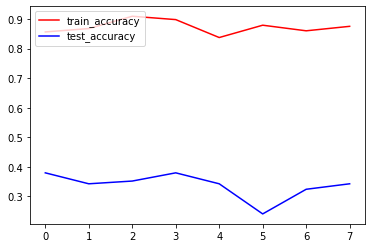

In [19]:
plt.plot(history.history["accuracy"], c="r", label="train_accuracy")
plt.plot(history.history["val_accuracy"], c="b", label="test_accuracy")
plt.legend(loc="upper left")
plt.show()

In [20]:
imgs, labels = next(iter(img_generator_flow_valid))
preds = model.predict(imgs)
pred_labels = tf.argmax(preds, axis = -1)

LABEL = []
for item in labels:
    LABEL += [np.argmax(item)]
print(LABEL)

PRED = pred_labels.numpy().tolist()

from sklearn.metrics import classification_report
print(classification_report(LABEL, PRED))

1/1 [==============================] - 1s 846ms/step
[6, 6, 1, 6, 5, 3, 6, 6, 3, 3, 1, 6, 2, 2, 3, 4, 5, 6, 2, 1, 3, 6, 1, 2, 6, 4, 3, 5, 6, 6, 5, 6]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         4
           2       0.25      0.25      0.25         4
           3       0.75      0.50      0.60         6
           4       0.00      0.00      0.00         2
           5       0.20      0.25      0.22         4
           6       0.56      0.83      0.67        12

    accuracy                           0.47        32
   macro avg       0.29      0.31      0.29        32
weighted avg       0.41      0.47      0.42        32



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
